In [1]:
%matplotlib inline


Forward Simulation with User-Defined Waveform on a Tree Mesh
============================================================

Here we use the module *SimPEG.electromagnetics.time_domain* to predict the
TDEM response for a trapezoidal waveform. We consider an airborne survey
which uses a horizontal coplanar geometry. For this tutorial, we focus
on the following:

    - How to define the transmitters and receivers
    - How to define more complicated transmitter waveforms
    - How to define the time-stepping
    - How to define the survey
    - How to solve TDEM problems on an OcTree mesh
    - How to include topography
    - The units of the conductivity model and resulting data


Please note that we have used a coarse mesh and larger time-stepping to shorten
the time of the simulation. Proper discretization in space and time is required
to simulate the fields at each time channel with sufficient accuracy.





Import Modules
--------------




In [2]:
from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz

from SimPEG.utils import plot2Ddata, surface2ind_topo
from SimPEG import maps
import SimPEG.electromagnetics.time_domain as tdem

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import interpolate

import sys
sys.path.append("..")
from MonteCarlo import MonteCarlo

from shapely.geometry import Point, Polygon

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

save_file = False

# sphinx_gallery_thumbnail_number = 3

Defining Topography
-------------------

Here we define surface topography as an (N, 3) numpy array. Topography could
also be loaded from a file. Here we define flat topography, however more
complex topographies can be considered.




/home/ammilten/anaconda3/envs/aemf/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


Text(0, 0.5, 'y')

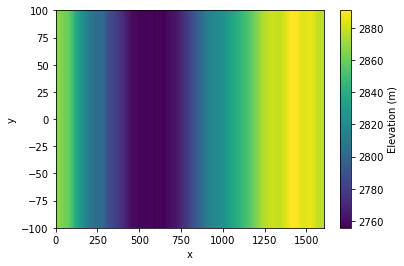

In [3]:
efile = '../data/PH-2018-eloc.txt'
eloc = pd.read_csv(efile,sep='\t',header=None)
x = eloc.values[:,1]
z = eloc.values[:,3]

y0 = 100
ny = 11
y = np.linspace(-y0, y0, ny)
yy = np.repeat(y[:,np.newaxis],x.shape[0],axis=1)
xx = np.repeat(x[:,np.newaxis],ny,axis=1).T
zz = np.repeat(z[:,np.newaxis],ny,axis=1).T

topo_xyz = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

plt.pcolormesh(xx,yy,zz)
cb = plt.colorbar()
cb.ax.set_ylabel('Elevation (m)')
plt.xlabel('x')
plt.ylabel('y')

Defining the Waveform
---------------------

Under *SimPEG.electromagnetic.time_domain.sources*
there are a multitude of waveforms that can be defined (VTEM, Ramp-off etc...).
Here, we consider a trapezoidal waveform, which consists of a
linear ramp-on followed by a linear ramp-off. For each waveform, it
is important you are cognizant of the off time!!!




/home/ammilten/anaconda3/envs/aemf/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Waveform')

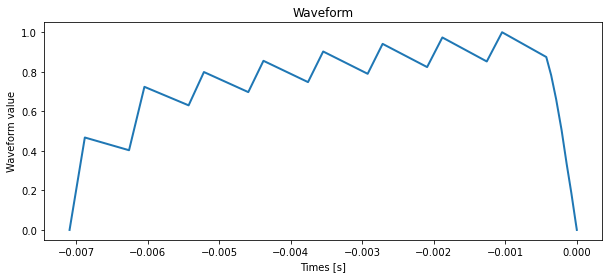

In [4]:
wfile = '../data/waveform.txt'
tfile = '../data/time_gates.txt'
wave = pd.read_csv(wfile,sep=' ')
timegates = pd.read_csv(tfile,sep='   ')

def wave_function(t):
    wfile = '../data/waveform.txt'
    wave = pd.read_csv(wfile,sep=' ')
    if t < wave.Time.values[0] or t > wave.Time.values[wave.Time.values.shape[0]-1]:
        val = 0
    else:
        w = interpolate.interp1d(wave.Time.values,wave.Amperes_Normalized)
        val = w(t)
    return val

waveform = tdem.sources.RawWaveform(waveFct=wave_function, offTime=0.)
waveform_times = wave.Time.values
waveform_value = wave.Amperes_Normalized

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(111)
ax1.plot(waveform_times, waveform_value, lw=2)
ax1.set_xlabel("Times [s]")
ax1.set_ylabel("Waveform value")
ax1.set_title("Waveform")

Create Airborne Survey
----------------------

Here we define the survey used in our simulation. For time domain
simulations, we must define the geometry of the source and its waveform. For
the receivers, we define their geometry, the type of field they measure and
the time channels at which they measure the field. For this example,
the survey consists of a uniform grid of airborne measurements.




Text(0, 0.5, 'Elevation (m)')

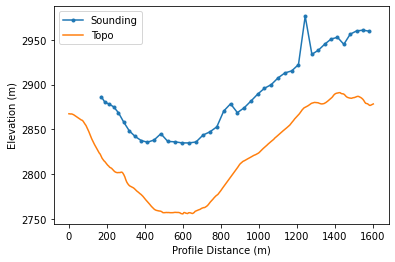

In [5]:
dfile = '../data/RawAEMData.csv'
dat = pd.read_csv(dfile)
lines = np.unique(dat.LINE)
k=9
dat2 = dat[dat.LINE == lines[k]]

efile = '../data/Cross-PH.txt'
efile2 = '../data/PH-2018-eloc.txt'
ert = pd.read_csv(efile, sep='\t')
ert2 = pd.read_csv(efile2,sep='\t',header=None)

Xert = np.concatenate(([ert.Easting.values],[ert.Northing.values]),axis=0).T
Yert = ert2.values[:,1]
reg = LinearRegression().fit(Xert, Yert)
Xaem = np.concatenate(([dat.X[dat.LINE == lines[k]].values],[dat.Y[dat.LINE == lines[k]].values]),axis=0).T
Yaem = reg.predict(Xaem)

xtx = Yaem[Yaem <= Yert[Yert.shape[0]-1]]
ytx = np.zeros(xtx.shape)
ztx = dat2.ALT.values[Yaem <= Yert[Yert.shape[0]-1]] + dat2.TOPO.values[Yaem <= Yert[Yert.shape[0]-1]]

# xtx = Yaem
# ytx = np.zeros(xtx.shape)
# ztx = dat2.ALT.values

# xtx = Yaem[0:2]
# ytx = np.zeros(xtx.shape)
# ztx = dat2.ALT.values[0:2]

xrx = xtx
yrx = ytx
zrx = ztx

source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

time_channels = timegates.Gatecenter.values
source_list = []  # Create empty list to store sources
for ii in range(xtx.shape[0]):

    # Here we define receivers that measure the h-field in A/m
    dbzdt_receiver = tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_locations[ii, :], time_channels, "z"
    )
    receivers_list = [
        dbzdt_receiver
    ]  # Make a list containing all receivers even if just one

    # Must define the transmitter properties and associated receivers
    source_list.append(
        tdem.sources.MagDipole(
            receivers_list,
            location=source_locations[ii],
            waveform=waveform,
            moment=1.0,
            orientation="z",
        )
    )

survey = tdem.Survey(source_list)

plt.plot(xtx,ztx,'.-',label='Sounding')
plt.plot(topo_xyz[:,0],topo_xyz[:,2],label='Topo')
plt.legend()
plt.xlabel('Profile Distance (m)')
plt.ylabel('Elevation (m)')

Create OcTree Mesh
------------------

Here we define the OcTree mesh that is used for this example.
We chose to design a coarser mesh to decrease the run time.
When designing a mesh to solve practical time domain problems:

    - Your smallest cell size should be 10%-20% the size of your smallest diffusion distance
    - The thickness of your padding needs to be 2-3 times biggest than your largest diffusion distance
    - The diffusion distance is ~1260*np.sqrt(rho*t)
    




In this next cell we call on some wrappers to create a list of points representing the fault zone. See the notebook called "AEM Simulation.ipynb" for more demonstration about how the wrappers work.

In [6]:
MCfolder = '../data/tmp/'
N=50

dip = [25, 165] #uniform
H = [120, 40] #normal
xpos = [400,40] #normal
rho_fault = [20, 10, .45] #lognormal
rho_back = [40, 30, .8] #lognormal

dep = 1000 #Minimum depth within domain (m)
xtra = 1000 #Buffer on each end of electrodes
dh = 50
y0 = 100
ny = 11

seed = 0
overwrite = True
parallel = False
nproc = None
showDists = True
saveParams=True

MC = MonteCarlo(dep,
                xtra, 
                dh,
                y0,
                ny,
                dip, 
                H, 
                xpos,
                rho_fault, 
                rho_back, 
                N, 
                MCfolder, 
                overwrite=overwrite, 
                parallel=parallel, 
                nproc=nproc, 
                seed=seed,
                showDists=showDists, 
                saveParams=saveParams)

r=9
setup = MC.prepare_realization(r)
fpts = setup.fpts
fault = Polygon(fpts)



MC folder already exists. Overwriting.


To create the mesh we first create a grid, then refine it over the surface, transmitters and receivers, and the fault zone.

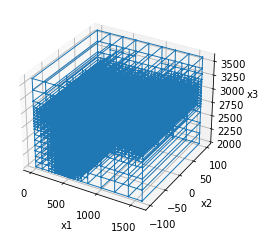

OcTreeMesh: 16.56% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  1   :       22             ---------------------------   --------------------
  2   :       120         x:      0.0     ,   1600.0          25.0   ,   200.0   
  3   :      1220         y:    -100.0    ,    100.0          25.0   ,   200.0   
  4   :      4064         z:    2000.0    ,   3600.0          25.0   ,   200.0   
-----------------------
Total :      5426

In [7]:
dh = 25.0  # base cell width
dom_width = x[x.shape[0]-1]  # domain width
dom_len = 2*y0
dom_vert = 1600
nbcx = 2 ** int(np.round(np.log(dom_width / dh) / np.log(2.0)))  # num. base cells
nbcy = 2 ** int(np.round(np.log(dom_len / dh) / np.log(2.0)))  # num. base cells
nbcz = 2 ** int(np.round(np.log(dom_vert / dh) / np.log(2.0)))  # num. base cells

# Define the base mesh
mesh = TreeMesh([[(dh, nbcx)], [(dh, nbcy)], [(dh, nbcz)]], x0=[0, -y0, 2000])

# Mesh refinement based on topography
mesh = refine_tree_xyz(
    mesh, topo_xyz, octree_levels=[0, 0, 0, 1], method="surface", finalize=False
)

# Mesh refinement near transmitters and receivers
mesh = refine_tree_xyz(
    mesh, receiver_locations, octree_levels=[2, 4], method="radial", finalize=False
)

# Refine core mesh region
xz = np.repeat(np.array(fpts),mesh.vectorCCy.shape[0],axis=0)
ys = np.concatenate(tuple([np.repeat(mesh.vectorCCy[i],len(fpts)) for i in range(mesh.vectorCCy.shape[0])]))
xyz = np.concatenate((xz[:,0][:,np.newaxis], ys[:,np.newaxis], xz[:,1][:,np.newaxis]),axis=1)

mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2, 4], method="box", finalize=False)

mesh.finalize()
mesh.plotGrid(show_it=True)
mesh

Create Conductivity Model and Mapping for OcTree Mesh
-----------------------------------------------------

Here, we define the electrical properties of the Earth as a conductivity
model. The model consists of a conductive block within a more
resistive background.




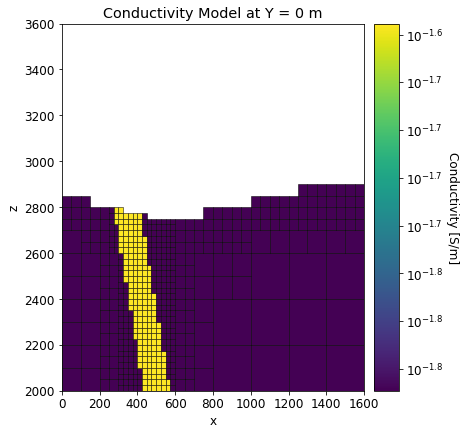

In [8]:
# Conductivity in S/m
air_conductivity = 1e-8
background_conductivity = 1/setup.rho_back
block_conductivity = 1/setup.rho_fault

# Active cells are cells below the surface.
ind_active = surface2ind_topo(mesh, topo_xyz)
model_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)

# Define the model
model = background_conductivity * np.ones(ind_active.sum())

inds_fault = np.array([Point(mesh.gridCC[i,0],mesh.gridCC[i,2]).within(fault) for i in range(mesh.nC)])
inds_fault = inds_fault[ind_active]

model[inds_fault] = block_conductivity

# Plot log-conductivity model
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 6))

log_model = np.log10(model)

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.13, 0.1, 0.6, 0.85])
mesh.plotSlice(
    plotting_map * log_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.hy.size / 2),
    grid=True,
    clim=(np.min(log_model), np.max(log_model)),
)
ax1.set_title("Conductivity Model at Y = 0 m")

ax2 = fig.add_axes([0.75, 0.1, 0.05, 0.85])
norm = mpl.colors.Normalize(vmin=np.min(log_model), vmax=np.max(log_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)

Define the Time-Stepping
------------------------

Stuff about time-stepping and some rule of thumb




In [9]:
t0w = wave.Time.values[0]

dtw = np.array([j-i for i, j in zip(wave.Time.values[:-1], wave.Time.values[1:])])

t0g = timegates.Gatecenter.values[0]
dtg = timegates.Gatewidth.values

time_steps = np.concatenate((dtw, [t0g], dtg))


Simulation: Time-Domain Response
--------------------------------

Here we define the formulation for solving Maxwell's equations. Since we are
measuring the time-derivative of the magnetic flux density and working with
a resistivity model, the EB formulation is the most natural. We must also
remember to define the mapping for the conductivity model.
We defined a waveform 'on-time' is from -0.002 s to 0 s. As a result, we need
to set the start time for the simulation to be at -0.002 s.




In [10]:
simulation = tdem.simulation.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, sigmaMap=model_map, Solver=Solver, t0=t0w
)

# Set the time-stepping for the simulation
simulation.time_steps = time_steps

# Predict data for a given model
dpred = simulation.dpred(model)

Plot Data
---------------------




/home/ammilten/anaconda3/envs/aemf/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()
/home/ammilten/anaconda3/envs/aemf/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


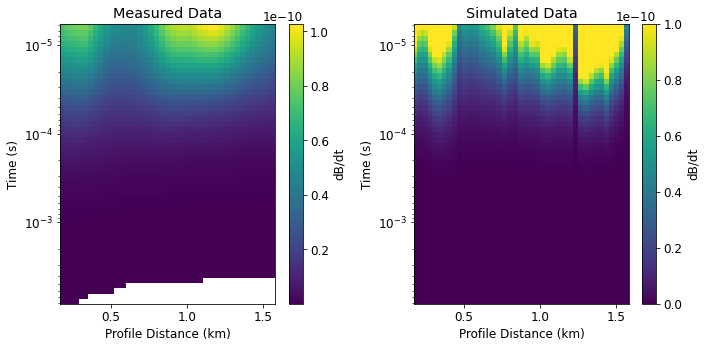

In [11]:
dpred_plotting = np.reshape(dpred, (source_locations.shape[0], timegates.Gatecenter.shape[0]))

xv,yv = np.meshgrid(receiver_locations[:,0],timegates.Gatecenter)

dat2 = dat[dat.LINE == lines[k]]
Z = dat2.values[:,1:53]
for i in range(52):
    Z[:,i] = dat2.get('DATA_'+str(i)).values
Z[Z==9999] = np.nan

Z2 = Z[Yaem <= ert2.values[ert2.values.shape[0]-1,1],:]


plt.subplots(nrows=1,ncols=2,figsize=(10,5))
plt.subplot(121)
plt.pcolormesh(xv/1000,yv,Z2.T)
plt.gca().invert_yaxis()
cb=plt.colorbar()
cb.ax.set_ylabel('dB/dt')
plt.yscale('log')
plt.xlabel('Profile Distance (km)')
plt.ylabel('Time (s)')
plt.title('Measured Data')

plt.subplot(122)
plt.pcolormesh(xv/1000,yv,np.abs(dpred_plotting.T),vmin=0,vmax=1e-10)
plt.gca().invert_yaxis()
cb=plt.colorbar()
cb.ax.set_ylabel('dB/dt')
plt.yscale('log')
plt.xlabel('Profile Distance (km)')
plt.ylabel('Time (s)')
plt.title('Simulated Data')

plt.tight_layout()

